In [25]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf
import os
import time
import gc
import re
from unidecode import unidecode

Get reproducable results

In [26]:
from numpy.random import seed
from tensorflow import set_random_seed

seed(726)
set_random_seed(726)

### Loading the training and testing files

In [27]:
train = pd.read_csv("data/train_en.tsv", sep='\t')
test = pd.read_csv("data/test_en.tsv", sep='\t')

print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (256929, 5)
Test shape :  (64233, 5)


In [28]:
train[:5]

,Unnamed: 0,id,human,gender,tweet
0,212717,ae5956bd7e744601958008c9514cf1d6,human,male,Mobile usability: have useful help screens htt...
1,320629,ff8c26db7278a3b51dba5e5db3f1d1ac,human,female,"Private VIP Access to Inner-Circle, Top-Secret..."
2,317601,fdbc9215acb1c676b4592987867c04b8,human,female,The Grinch in chief https://t.co/LhUkvXyAfr'
3,230018,b9781bb0eebf3143367f245f4fbad019,bot,bot,Grubby Protesters. Not Honest!'
4,112325,6586c6858b0aab51410eab76b693714d,bot,bot,"A business has to be involving, it has to be f..."


In [29]:
test[:5]

,Unnamed: 0,id,human,gender,tweet
0,243250,c32c35b3970fe4cf88df7eb9e3f77719,bot,bot,Check Out this Introduction To http://t.co/zW5...
1,267621,d63fb6d001dfc88c4947629dc7243791,bot,bot,Inside Sales Representative: Alro Steel is cur...
2,308448,f6ca0df6b6b20238d59395d8340c6c6f,human,female,@meaghano It is good but it’s also kind of wei...
3,200213,a47dd96330a9d82cac33b20bc0319366,bot,bot,Great Questions to Ask a Lawyer Prior to Hirin...
4,293982,eb0ce5669d9adf9aad68880aaba6bcf,human,male,RT @LeeannDempster: On our season ticket sales...


Changing case of the tweets to lower case, since the embedding model only has lower case words

In [30]:
train["tweet"] = train["tweet"].str.lower()
test["tweet"] = test["tweet"].str.lower()

cleaning the puncutation marks

In [31]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):

    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x


train["tweet"] = train["tweet"].apply(lambda x: clean_text(x))
test["tweet"] = test["tweet"].apply(lambda x: clean_text(x))

visualize word distribution

/home/tharindu/anaconda3/envs/sentence_similarity_3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


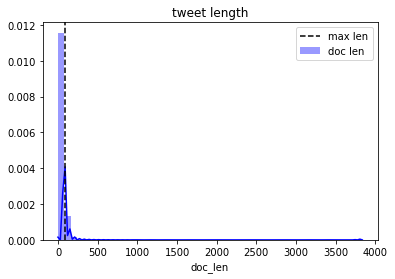

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

train['doc_len'] = train["tweet"].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train['doc_len'].mean() + train['doc_len'].std()).astype(int)
sns.distplot(train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('tweet length'); plt.legend()
plt.show()

In [33]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = None # how many unique words to use (i.e num rows in embedding vector)
maxlen = max_seq_len # max number of words in a question to use #99.99%

## fill up the missing values
X = train["tweet"].fillna("_na_").values
print("Test shape : ", test.shape)
X_test = test["tweet"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters='')
tokenizer.fit_on_texts(list(X))

X = tokenizer.texts_to_sequences(X)
X_test = tokenizer.texts_to_sequences(X_test)

## Pad the sentences 
X = pad_sequences(X, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

## Get the target values
Y = train['human'].values


Test shape :  (64233, 5)


In [34]:
train.human.value_counts()

bot      132940
human    123989
Name: human, dtype: int64

In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(Y)
encoded_Y = le.transform(Y)
encoded_Y

array([1, 1, 1, ..., 0, 1, 0])

Building the Embedding matrix

In [36]:
word_index = tokenizer.word_index
max_features = len(word_index)+1
def load_glove(word_index):
    EMBEDDING_FILE = '/data/glove/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if o.split(" ")[0] in word_index)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 
    
def load_fasttext(word_index):    
    EMBEDDING_FILE = '/data/fasttext/crawl-300d-2M-subword.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100 and o.split(" ")[0] in word_index )

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

Only Glove vectors have been used in embedding matrix. Can explore it further in future

In [37]:
embedding_matrix = load_fasttext(word_index)

/home/tharindu/anaconda3/envs/sentence_similarity_3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Definning the Capsule Layer in Keras

In [38]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale

In [39]:
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     # shape=self.kernel_size,
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
            
    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        # final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  # shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))  # shape = [None, input_num_capsule, num_capsule]
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(K.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(outputs, u_hat_vecs, [2, 3])

        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

Capsule Layer with a Bi directional GRU. Architecture found in text classification project.

In [40]:
def capsule():
    K.clear_session()       
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = SpatialDropout1D(rate=0.2)(x)
    x = Bidirectional(GRU(100, return_sequences=True, 
                                kernel_initializer=glorot_normal(seed=12300), recurrent_initializer=orthogonal(gain=1.0, seed=10000)))(x)

    x = Capsule(num_capsule=10, dim_capsule=10, routings=4, share_weights=True)(x)
    x = Flatten()(x)

    x = Dense(100, activation="relu", kernel_initializer=glorot_normal(seed=12300))(x)
    x = Dropout(0.12)(x)
    x = BatchNormalization()(x)

    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer=Adam(),)
    return model

In [41]:
def f1_smart(y_true, y_pred):
    args = np.argsort(y_pred)
    tp = y_true.sum()
    fs = (tp - np.cumsum(y_true[args[:-1]])) / np.arange(y_true.shape[0] + tp - 1, tp, -1)
    res_idx = np.argmax(fs)
    return 2 * fs[res_idx], (y_pred[args[res_idx]] + y_pred[args[res_idx + 1]]) / 2

Training with early stopping and reducing learning rate on plateu. In each fold values for the test set is also predicted, And after the process, predicted values for the test file would be mean from each fold

In [43]:
kfold = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
bestscore = []
y_test = np.zeros((X_test.shape[0], ))
for i, (train_index, valid_index) in enumerate(kfold.split(X, encoded_Y)):
    X_train, X_val, Y_train, Y_val = X[train_index], X[valid_index], encoded_Y[train_index], encoded_Y[valid_index]
    filepath="models/capsule_net_weights_best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=1, min_lr=0.0001, verbose=2)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=2, mode='auto')
    callbacks = [checkpoint, reduce_lr]
    model = capsule()
    if i == 0:print(model.summary()) 
    model.fit(X_train, Y_train, batch_size=64, epochs=6, validation_data=(X_val, Y_val), verbose=2, callbacks=callbacks, 
             )
    model.load_weights(filepath)
    y_pred = model.predict([X_val], batch_size=64, verbose=2)
    y_test += np.squeeze(model.predict([X_test], batch_size=64, verbose=2))/5
    f1, threshold = f1_smart(np.squeeze(Y_val), np.squeeze(y_pred))
    print('Optimal F1: {:.4f} at threshold: {:.4f}'.format(f1, threshold))
    bestscore.append(threshold)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 85)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 85, 300)           116578200 
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 85, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 85, 200)           240600    
_________________________________________________________________
capsule_1 (Capsule)          (None, 10, 10)            20000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
__________

Converting the predictions for integer.

In [44]:
y_test = y_test.reshape((-1, 1))
pred_test_y = (y_test>np.mean(bestscore)).astype(int)
test['predictions'] = le.inverse_transform(pred_test_y)

/home/tharindu/anaconda3/envs/sentence_similarity_3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:273: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Confusion Matrix

In [47]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test["human"], test['predictions']).ravel()
(tn, fp, fn, tp)

(31565, 1889, 779, 30000)

### Accuracy

In [49]:
from sklearn.metrics import accuracy_score
accuracy_score(test["human"], test['predictions'])

0.9584637180265596